In [17]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

import discretize
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz

from SimPEG import (
    maps,
    optimization,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    Report,
)
from SimPEG.electromagnetics import frequency_domain as fdem

## Setup

In [18]:
sigma_surface = 1/1000
sigma_middle = 1/10
sigma_deep = 1/100
sigma_air = 1e-8

## Forward Modelling Mesh

the mesh has 15456 cells


C:\Users\sabri\AppData\Local\Temp\ipykernel_12672\732905370.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncx = int(np.diff(core_domain_x) / csx)
C:\Users\sabri\AppData\Local\Temp\ipykernel_12672\732905370.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ncz = int(np.diff(core_domain_z) / csz)


<Axes3D: xlabel='x1', ylabel='x2', zlabel='x3'>

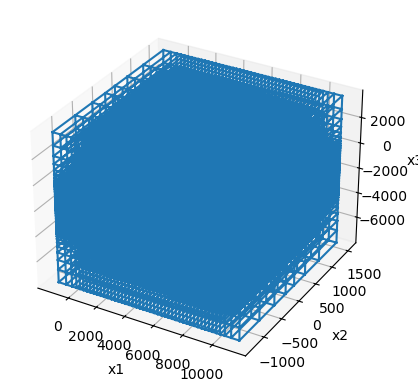

In [19]:
csx = 0.25e3  # cell size for the horizontal direction
csz = 0.125e3  # cell size for the vertical direction
pf = 1.3  # expansion factor for the padding cells

npadx = 3  # number of padding cells in the x-direction
npady = 3  # number of padding cells in the y-direction
npadz = 8  # number of padding cells in the z-direction

core_domain_x = np.r_[0.0, 10.0e3]  # extent of uniform cells in the x-direction
core_domain_z = np.r_[-4.0e3, 0.0]  # extent of uniform cells in the z-direction

# number of cells in the core region
ncx = int(np.diff(core_domain_x) / csx)
ncz = int(np.diff(core_domain_z) / csz)

# create a 3D tensor mesh
mesh = discretize.TensorMesh(
    [
        [(csx, npadx, -pf), (csx, ncx), (csx, npadx, pf)],
        [(csx, npady, -pf), (csx, 1), (csx, npady, pf)],
        [(csz, npadz, -pf), (csz, ncz), (csz, npadz, pf)],
    ]
)

mesh.x0 = np.r_[
    -mesh.h[0][: npadx].sum(), -mesh.h[1][: npady].sum(), -mesh.h[2][: npadz + ncz].sum()
]

print("the mesh has {} cells".format(mesh.nC))
mesh.plot_grid()

## Inversion Mesh

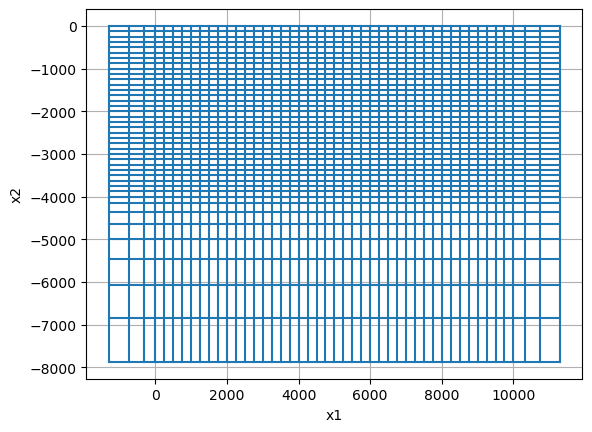

In [20]:
inversion_mesh = discretize.TensorMesh([mesh.h[0], mesh.h[2][mesh.cell_centers_z <= 0]])
inversion_mesh.x0 = [-inversion_mesh.h[0][mesh.cell_centers_x <= 0].sum(), -inversion_mesh.h[1].sum()]
ax = inversion_mesh.plot_grid()

## True Model

In [21]:
z_interface_shallow_top = -0.5e3
z_interface_deep_top = -1.0e3
x_dip_top = np.r_[5.0e3, 9.0e3]

z_interface_shallow_middle = -1.0e3
z_interface_deep_middle = -2.5e3
x_dip_middle = np.r_[2.0e3, 7.0e3]

In [22]:
def interface(x):
    # Top Interface
    interface_1 = np.zeros_like(x)
    interface_1[x < x_dip_top[0]] = z_interface_shallow_top
    dipping_unit_top = (x >= x_dip_top[0]) & (x <= x_dip_top[1])
    x_dipping_top = (-(z_interface_shallow_top - z_interface_deep_top) / (x_dip_top[1]- x_dip_top[0])) * (x[dipping_unit_top])
    x_dipping_top = x_dipping_top - x_dipping_top[0] + z_interface_shallow_top
    interface_1[dipping_unit_top] = x_dipping_top
    interface_1[x > x_dip_top[1]] = z_interface_deep_top

    # Middle Interface
    interface_2 = np.zeros_like(x)
    dipping_unit_middle = (x >= x_dip_middle[0]) & (x <= x_dip_middle[1])
    x_dipping_middle = (-(z_interface_shallow_middle - z_interface_deep_middle) / (x_dip_middle[1]-x_dip_middle[0])) * (x[dipping_unit_middle])
    x_dipping_middle = x_dipping_middle - x_dipping_middle[0] + z_interface_shallow_middle
    interface_2[dipping_unit_middle] = x_dipping_middle
    interface_2[x > x_dip_middle[1]] = z_interface_deep_middle

    return interface_1, interface_2

(-4000.0, 0.0)

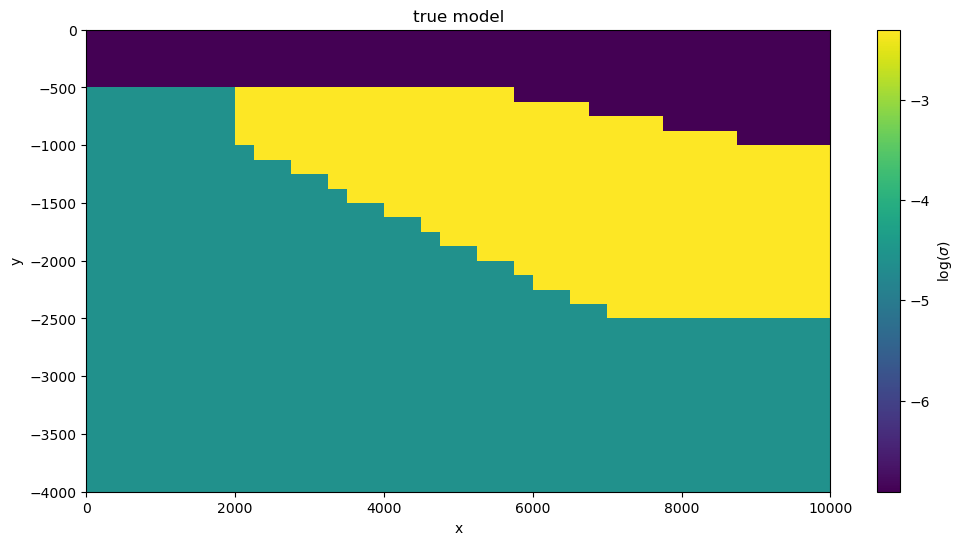

In [63]:
m_true = np.log(sigma_deep) * np.ones(inversion_mesh.nC)
interface_depth_1, interface_depth_2 = interface(inversion_mesh.gridCC[:, 0])
m_true[inversion_mesh.gridCC[:, 1] > interface_depth_2] = np.log(sigma_middle)
m_true[inversion_mesh.gridCC[:, 1] > interface_depth_1] = np.log(sigma_surface)

fig, ax = plt.subplots(1, 1, figsize=(12,6))
cb = plt.colorbar(inversion_mesh.plot_image(m_true, ax=ax)[0], ax=ax)
cb.set_label(r"$\log(\sigma)$")
ax.set_title("true model")
ax.set_xlim([0, 10.0e3])
ax.set_ylim([-4.0e3, 0])
# ax.minorticks_on()
# ax.grid(True, which="both")

## Mapping

In [58]:
# create a 2D mesh that includes air cells
mesh2D = discretize.TensorMesh([mesh.h[0], mesh.h[2]], x0=mesh.x0[[0, 2]])
active_inds = mesh2D.gridCC[:, 1] < 0  # active indices are below the surface


# 3D Mapping
mapping = (
    maps.Surject2Dto3D(mesh)
    * maps.InjectActiveCells(  # populates 3D space from a 2D model
        mesh2D, active_inds, sigma_air
    )
    * maps.ExpMap(  # adds air cells
        nP=inversion_mesh.nC
    )  # takes the exponential (log(sigma) --> sigma)
)

## Create Airborne Survey

In [97]:
frequencies = np.logspace(-2, 6, 10)
sep = 10 # 10m separation
# Defining transmitter locations
xtx, ytx, ztx = np.meshgrid(np.arange(1000, 10000, 1000), [0], [30])
source_locations = np.c_[mkvc(xtx), mkvc(ytx), mkvc(ztx)]
ntx = np.size(xtx)

# Define receiver locations
xrx, yrx, zrx = np.meshgrid(np.arange(1000, 10000, 1000) + sep, [0], [30])
receiver_locations = np.c_[mkvc(xrx), mkvc(yrx), mkvc(zrx)]

source_list = []  # Create empty list to store sources

# Each unique location and frequency defines a new transmitter

# Each unique location and frequency defines a new transmitter
for ii in range(len(frequencies)):
    for jj in range(ntx):
        # Define receivers of different type at each location
        bzr_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
            receiver_locations[jj, :], "z", "real"
        )
        bzi_receiver = fdem.receivers.PointMagneticFluxDensitySecondary(
            receiver_locations[jj, :], "z", "imag"
        )
        receivers_list = [bzr_receiver, bzi_receiver]

        # Must define the transmitter properties and associated receivers
        source_list.append(
            fdem.sources.MagDipole(
                receivers_list,
                frequencies[ii],
                source_locations[jj],
                orientation="z",
                moment=100,
            )
        )

# # create the survey and problem objects for running the forward simulation
survey = fdem.Survey(source_list)
prob = fdem.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, sigmaMap=mapping, solver=Solver
)

In [98]:
dpred = prob.dpred(m_true)

In [99]:
len(dpred)

180

In [100]:
dpred

array([-2.77865284e-16,  6.32495925e-15, -2.58744358e-16,  6.24952490e-15,
       -2.38919367e-16,  6.17881949e-15, -2.31370106e-16,  6.16042201e-15,
       -2.31994255e-16,  6.16732646e-15, -2.47366828e-16,  6.24416918e-15,
       -2.69940170e-16,  6.33373469e-15, -2.89271502e-16,  6.39355276e-15,
       -3.01117649e-16,  6.42942197e-15, -1.02521276e-14,  4.25873611e-14,
       -9.92105872e-15,  4.25693669e-14, -9.63319602e-15,  4.25617586e-14,
       -9.58592806e-15,  4.26047864e-14, -9.63683230e-15,  4.26115880e-14,
       -1.00049547e-14,  4.27408434e-14, -1.04107355e-14,  4.27705024e-14,
       -1.06332941e-14,  4.26987044e-14, -1.07589974e-14,  4.26302078e-14,
       -1.19446323e-13,  1.72958074e-13, -1.19566204e-13,  1.73013984e-13,
       -1.19678077e-13,  1.73066390e-13, -1.19675378e-13,  1.73063244e-13,
       -1.19668525e-13,  1.73071595e-13, -1.19468755e-13,  1.72859219e-13,
       -1.19297858e-13,  1.72841709e-13, -1.19264928e-13,  1.72879722e-13,
       -1.19269399e-13,  

In [93]:
m_true
np.exp(m_true)

array([0.01 , 0.01 , 0.01 , ..., 0.001, 0.001, 0.001])

In [94]:
dpred = prob.dpred(np.exp(m_true))

In [95]:

dpred

array([-3.11891851e-24, -1.92894910e-20, -1.86528410e-22, -1.49350974e-19,
       -1.11757580e-20, -1.15611541e-18, -6.45783762e-19, -8.83717734e-18,
       -1.62748515e-17, -5.23637173e-17, -9.02410481e-17, -2.41385028e-16,
       -5.93866862e-16, -1.17142761e-15, -3.49404041e-15, -2.51481392e-15,
       -6.61590781e-15, -1.09136876e-15, -6.89414746e-15, -1.52664307e-16,
       -1.25529934e-23, -3.32939598e-20, -7.51899087e-22, -2.57778805e-19,
       -4.49634619e-20, -1.99392955e-18, -2.38097836e-18, -1.46853130e-17,
       -3.50908493e-17, -6.41530709e-17, -1.19857935e-16, -2.33095689e-16,
       -5.85230592e-16, -1.16191933e-15, -3.49410909e-15, -2.51474326e-15,
       -6.61590327e-15, -1.09137107e-15, -6.89414317e-15, -1.52664734e-16,
       -7.70170194e-23, -7.81120032e-20, -4.61396418e-21, -6.04742092e-19,
       -2.74255086e-19, -4.65899013e-18, -1.15176751e-17, -2.92080396e-17,
       -6.87345277e-17, -7.11157058e-17, -1.51157820e-16, -2.18342683e-16,
       -5.76253722e-16, -

In [88]:
dpred

array([-2.77865285e-18,  6.32495925e-17, -1.02521276e-16,  4.25873611e-16,
       -1.19446323e-15,  1.72958074e-15, -4.81605373e-15,  2.40047597e-15,
       -6.81695260e-15,  6.00078572e-16, -6.89789569e-15,  7.92042554e-17,
       -6.89928450e-15,  1.02321797e-17, -6.89930768e-15,  1.31204727e-18,
       -6.89930809e-15,  9.59201629e-20, -6.89930947e-15, -5.56969284e-19,
       -2.58744357e-18,  6.24952495e-17, -9.92105905e-17,  4.25693668e-16,
       -1.19566204e-15,  1.73013985e-15, -4.81604760e-15,  2.40049191e-15,
       -6.81694824e-15,  6.00079774e-16, -6.89789140e-15,  7.92044115e-17,
       -6.89928021e-15,  1.02321996e-17, -6.89930339e-15,  1.31204775e-18,
       -6.89930380e-15,  9.59040190e-20, -6.89930519e-15, -5.57096355e-19,
       -2.38919367e-18,  6.17881947e-17, -9.63319605e-17,  4.25617586e-16,
       -1.19678077e-15,  1.73066390e-15, -4.81604867e-15,  2.40050001e-15,
       -6.81694802e-15,  6.00079835e-16, -6.89789118e-15,  7.92044191e-17,
       -6.89927999e-15,  

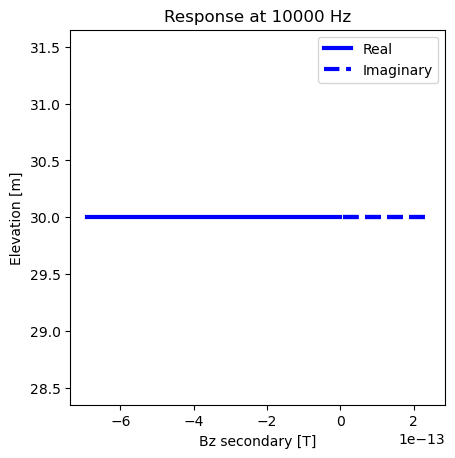

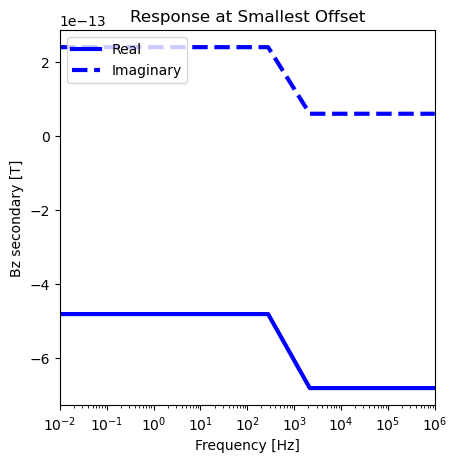

In [101]:
# Data are organized by transmitter location, then component, then frequency. We had nFreq
# transmitters and each transmitter had 2 receivers (real and imaginary component). So
# first we will pick out the real and imaginary data
bz_real = dpred[0 : len(dpred) : 2]
bz_imag = dpred[1 : len(dpred) : 2]

# Then we will will reshape the data.
bz_real = np.reshape(bz_real, (ntx, len(frequencies)))
bz_imag = np.reshape(bz_imag, (ntx, len(frequencies)))

# Plot secondary field along the profile at f = 10000 Hz
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.2, 0.15, 0.75, 0.75])
frequencies_index = 0
ax1.plot(bz_real[:, frequencies_index], receiver_locations[:, -1], "b-", lw=3)
ax1.plot(bz_imag[:, frequencies_index], receiver_locations[:, -1], "b--", lw=3)
ax1.set_xlabel("Bz secondary [T]")
ax1.set_ylabel("Elevation [m]")
ax1.set_title("Response at 10000 Hz")
ax1.legend(["Real", "Imaginary"], loc="upper right")

# Plot FEM response for all frequencies
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.2, 0.15, 0.75, 0.75])
location_index = 3
ax1.semilogx(frequencies, bz_real[location_index, :], "b-", lw=3)
ax1.semilogx(frequencies, bz_imag[location_index, :], "b--", lw=3)
ax1.set_xlim((np.min(frequencies), np.max(frequencies)))
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Bz secondary [T]")
ax1.set_title("Response at Smallest Offset")
ax1.legend(["Real", "Imaginary"], loc="upper left")